## Baseline model 

As a baseline model we will use VGGNet 13, first with its pre-trained weights

In [3]:
import os
import torch
import torchvision
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
# 1. Load and prepare the dataset
class FootballDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        
        # Make sure img_names contains the actual filenames (strings)
        # If the index of labels_df is numeric, we need to convert properly
        self.img_names = [str(name) + '.jpg' if not str(name).endswith('.jpg') else str(name) 
                          for name in labels_df.index]
        
        # Vectorized label processing
        label_array = labels_df.values
        has_label = np.any(label_array, axis=1)
        self.labels = np.where(has_label, np.argmax(label_array, axis=1), 7)
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        try:
            # Only load the image when it's actually needed
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image {self.img_names[idx]}: {e}")
            # Return a placeholder image in case of errors
            placeholder = torch.zeros((3, 224, 224)) if self.transform else Image.new('RGB', (224, 224))
            return placeholder, self.labels[idx]


In [6]:
# 3. Load the labels
labels_df = pd.read_csv('selected_labels.csv', index_col=0)  

In [7]:
# 4. Split the dataset
train_idx, temp_idx = train_test_split(labels_df.index, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_df = labels_df.loc[train_idx]
val_df = labels_df.loc[val_idx]
test_df = labels_df.loc[test_idx]


In [11]:
# 5. Create DataLoaders
img_dir = 'data/selected_images' 

train_dataset = FootballDataset(img_dir, train_df, transform=data_transforms['train'])
print('done')
val_dataset = FootballDataset(img_dir, val_df, transform=data_transforms['val'])
print('2')
test_dataset = FootballDataset(img_dir, test_df, transform=data_transforms['test'])
print('3')

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


NameError: name 'data_transforms' is not defined

In [41]:
# 6. Load the pre-trained VGG13 model and modify it
vgg13 = models.vgg13(pretrained=True)

# Freeze the feature extraction layers (optional)
for param in vgg13.features.parameters():
    param.requires_grad = False

# Modify the classifier part for our 8 classes
num_classes = 8
vgg13.classifier[6] = nn.Linear(4096, num_classes)

# Move model to device
vgg13 = vgg13.to(device)

In [42]:
# 7. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg13.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [1]:
# 8. Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = train_loader if phase == 'train' else val_loader
            
            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass - track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if best val accuracy
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [44]:
# 9. Training the model
trained_model = train_model(vgg13, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------


  0%|          | 0/1126635 [00:00<?, ?it/s]


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'int'

In [ ]:
# 10. Save the trained model
torch.save(trained_model.state_dict(), 'football_vgg13_model.pth')

In [ ]:
# 11. Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    corrects = 0
    total = 0
    
    class_names = ['Start/Restart', 'Joy of players', 'Yellow card', 'Red Card', 
                   'Stadium View', 'Penalty', 'Free Kick', 'Generic Moment']
    
    # Confusion matrix
    conf_matrix = torch.zeros(len(class_names), len(class_names))
    
    # No gradient calculation needed
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                conf_matrix[t.long(), p.long()] += 1
                
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = 100 * corrects / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Display confusion matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add numbers to the plot
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f'{int(conf_matrix[i, j])}',
                     horizontalalignment='center',
                     color='white' if conf_matrix[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return accuracy, conf_matrix

In [ ]:
# Evaluate the model
test_accuracy, conf_matrix = evaluate_model(trained_model, test_loader)

In [ ]:
# 12. Inference function for new images
def predict_image(model, image_path, transform):
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        
    class_names = ['Start/Restart', 'Joy of players', 'Yellow card', 'Red Card', 
                   'Stadium View', 'Penalty', 'Free Kick', 'Generic Moment']
    
    return class_names[predicted.item()]


In [ ]:
# Example usage for inference
# example_image = "data/selected_images/some_image.jpg"
# prediction = predict_image(trained_model, example_image, data_transforms['test'])
# print(f"Predicted class: {prediction}")

In [ ]:
# 13. Batch inference for all test images
def batch_predict(model, image_dir, test_df, transform):
    model.eval()
    test_dataset = FootballDataset(image_dir, test_df, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    class_names = ['Start/Restart', 'Joy of players', 'Yellow card', 'Red Card', 
                   'Stadium View', 'Penalty', 'Free Kick', 'Generic Moment']
    
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(test_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            batch_files = test_df.index[i*32:i*32+inputs.size(0)]
            filenames.extend(batch_files)
            
            for pred in preds:
                predictions.append(class_names[pred.item()])
    
    # Create predictions DataFrame
    results_df = pd.DataFrame({
        'filename': filenames,
        'predicted_class': predictions
    })
    
    return results_df

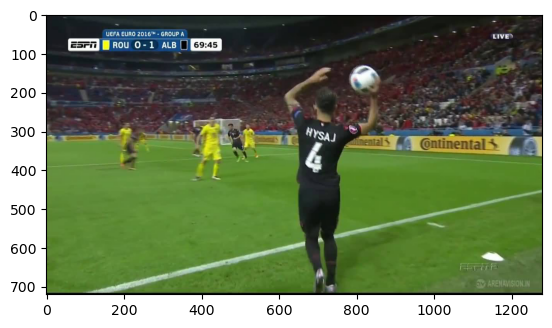

In [14]:
# show image 14147.jpg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('data/selected_images/14147.jpg')
plt.imshow(img)
